In [1]:
!pip install sparse_lmm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import pandas as pd
import numpy as np
TRAIT = 'Lung Cancer'
CONDITION = 'Inflammation'
data_root = './TCGA dataset'
clinical_data = pd.read_csv('TCGA dataset/TCGA_Lung_Cancer_(LUNG)/TCGA.LUNG.sampleMap_LUNG_clinicalMatrix', sep='\t', index_col=0)
gene_data = pd.read_csv('TCGA dataset/TCGA_Lung_Cancer_(LUNG)/TCGA.LUNG.sampleMap_HiSeqV2_PANCAN.gz', sep='\t', index_col=0)

In [17]:
CONDITION_COL = 'EGFR'

gene_list = gene_data.index.tolist()
num_genes = len(gene_list)
num_features = len(clinical_data.columns)
print(f'The clinical dataset has {num_features} features, and the gene dataset includes {num_genes} genes')

The clinical dataset has 133 features, and the gene dataset includes 20530 genes


In [19]:
# Merge clinical_data and gene_data on their indices - sample_ID, corresponding to each person
# Only select the column of condition feature in the clinical data
clinical_data = clinical_data[[CONDITION_COL]]
# Merge clinical_data and gene_data on their indices - sample_ID, corresponding to each person
merged_data = clinical_data.join(gene_data.T, rsuffix = '_gd')
merged_data.head()

,EGFR,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,NaN,-0.056592,2.128674,-0.531035,-0.185972,-0.190878,-0.11891,-0.659794,-1.204246,0.008601,...,0.015022,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812
TCGA-05-4249-01,none,-0.569692,-0.318126,-0.531035,0.237428,0.011822,-0.00611,1.018406,0.313854,-0.423399,...,-0.031778,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212
TCGA-05-4250-01,NaN,-0.899992,-0.918126,-0.531035,-0.621472,-0.454178,0.58719,-0.198894,-1.153846,-0.423399,...,-0.748878,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812
TCGA-05-4382-01,"p.R222L, p.E545Q",0.667508,3.895974,-0.221535,-0.367272,0.131822,0.97629,-0.494994,1.059554,0.357201,...,1.013722,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588
TCGA-05-4384-01,none,-0.316892,2.380374,0.156865,0.232828,0.054822,0.27059,0.128606,0.440354,-0.423399,...,-0.060978,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712


In [20]:

# Remove sample rows with missing columns.
threshold_rows = 0.8 * len(merged_data)
rows_after_any = len(merged_data.dropna(how='any'))

# Prefer "how='any'", if it does not discard too much data.
if rows_after_any >= threshold_rows:
    merged_data = merged_data.dropna(how='any')
else:
    merged_data = merged_data.dropna(how='all')
    merged_data = merged_data.fillna(0)

merged_data.head()

,EGFR,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,0,-0.056592,2.128674,-0.531035,-0.185972,-0.190878,-0.11891,-0.659794,-1.204246,0.008601,...,0.015022,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812
TCGA-05-4249-01,none,-0.569692,-0.318126,-0.531035,0.237428,0.011822,-0.00611,1.018406,0.313854,-0.423399,...,-0.031778,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212
TCGA-05-4250-01,0,-0.899992,-0.918126,-0.531035,-0.621472,-0.454178,0.58719,-0.198894,-1.153846,-0.423399,...,-0.748878,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812
TCGA-05-4382-01,"p.R222L, p.E545Q",0.667508,3.895974,-0.221535,-0.367272,0.131822,0.97629,-0.494994,1.059554,0.357201,...,1.013722,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588
TCGA-05-4384-01,none,-0.316892,2.380374,0.156865,0.232828,0.054822,0.27059,0.128606,0.440354,-0.423399,...,-0.060978,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712


In [24]:
# Decode the trait information from Sample IDs. Tumor types range from 01 - 09, normal types from 10 - 19.
# Create a function to check the last two digits of a row index

def mark_tumor(row_index):
    last_two_digits = int(row_index[-2:])

    if 1 <= last_two_digits <= 9:
        return 1
    elif 10 <= last_two_digits <= 19:
        return 0
    else:
        return -1

# Use the apply function to add the trait column to merged_data
merged_data[TRAIT] = merged_data.index.to_series().apply(mark_tumor)

merged_data.head()

,EGFR,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Lung Cancer
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,0,-0.056592,2.128674,-0.531035,-0.185972,-0.190878,-0.11891,-0.659794,-1.204246,0.008601,...,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812,1
TCGA-05-4249-01,none,-0.569692,-0.318126,-0.531035,0.237428,0.011822,-0.00611,1.018406,0.313854,-0.423399,...,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212,1
TCGA-05-4250-01,0,-0.899992,-0.918126,-0.531035,-0.621472,-0.454178,0.58719,-0.198894,-1.153846,-0.423399,...,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812,1
TCGA-05-4382-01,"p.R222L, p.E545Q",0.667508,3.895974,-0.221535,-0.367272,0.131822,0.97629,-0.494994,1.059554,0.357201,...,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588,1
TCGA-05-4384-01,none,-0.316892,2.380374,0.156865,0.232828,0.054822,0.27059,0.128606,0.440354,-0.423399,...,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712,1


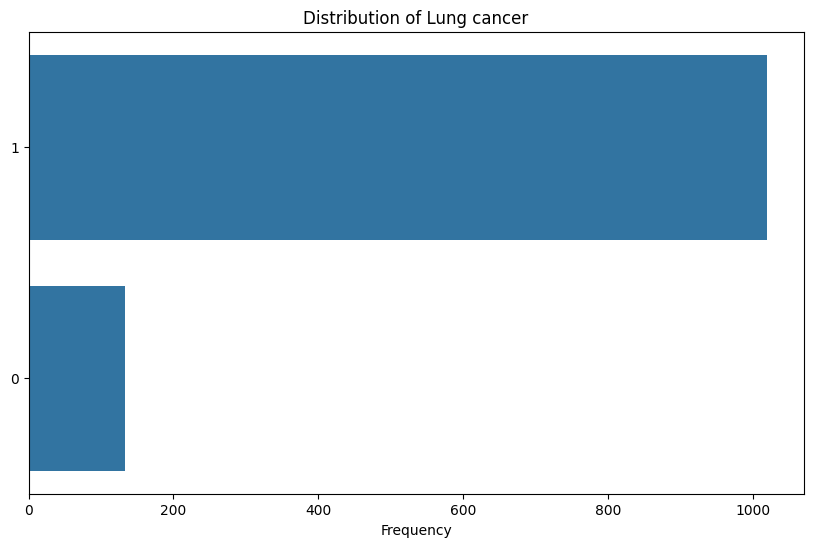

In [30]:

import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

def analyze_distributions(df, categorical_columns):

    for col in categorical_columns:
        plot_categorical_distribution(df, col)

# For example, we may want to choose a few genes we are interested in for visualization:
interested_genes = [col for col in gene_list if 'EGFR' in col.lower()]
analyze_distributions(merged_data, categorical_columns=[TRAIT])

In [35]:

merged_data = merged_data.rename(columns={CONDITION_COL: CONDITION})
feature_cols = merged_data.columns.tolist()[:-1]

merged_data.head()

,Inflammation,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Lung Cancer
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,0,-0.056592,2.128674,-0.531035,-0.185972,-0.190878,-0.11891,-0.659794,-1.204246,0.008601,...,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812,1
TCGA-05-4249-01,none,-0.569692,-0.318126,-0.531035,0.237428,0.011822,-0.00611,1.018406,0.313854,-0.423399,...,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212,1
TCGA-05-4250-01,0,-0.899992,-0.918126,-0.531035,-0.621472,-0.454178,0.58719,-0.198894,-1.153846,-0.423399,...,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812,1
TCGA-05-4382-01,"p.R222L, p.E545Q",0.667508,3.895974,-0.221535,-0.367272,0.131822,0.97629,-0.494994,1.059554,0.357201,...,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588,1
TCGA-05-4384-01,none,-0.316892,2.380374,0.156865,0.232828,0.054822,0.27059,0.128606,0.440354,-0.423399,...,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712,1


In [36]:

from sparse_lmm import VariableSelection

def normalize_data(X_train, X_test=None):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # Handling columns with std = 0
    std_no_zero = np.where(std == 0, 1, std)

    # Normalize X_train
    X_train_normalized = (X_train - mean) / std_no_zero
    # Set normalized values to 0 where std was 0
    X_train_normalized[:, std == 0] = 0

    if X_test is not None:
        X_test_normalized = (X_test - mean) / std_no_zero
        X_test_normalized[:, std == 0] = 0
    else:
        X_test_normalized = None

    return X_train_normalized, X_test_normalized

In [37]:

def cross_validation(X, y, k=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    fold_size = len(X) // k
    accuracies = []

    for i in range(k):
        # Split data into train and test based on the current fold
        test_indices = indices[i*fold_size : (i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Preprocess the train and test data
        X_train, X_test = normalize_data(X_train, X_test)

        # Use the precision_lasso package for regression
        var_select = VariableSelection()
        var_select.fit(X_train, y_train)
        predictions = var_select.predict(X_test)

        # Turn the predictions into binary values using a threshold of 0.5
        binary_predictions = (predictions > 0.5).astype(int)

        # Calculate accuracy for this fold
        accuracy = np.mean(binary_predictions == y_test)
        accuracies.append(accuracy)

    return np.mean(accuracies), np.std(accuracies)

In [41]:

# Select relevant columns and convert to numpy array
merged_data = merged_data.replace('none', 0)
merged_data = merged_data.apply(pd.to_numeric, errors='coerce').fillna(0)
y = merged_data[TRAIT].values
X = merged_data.drop(columns=[TRAIT]).values

cv_mean, cv_std = cross_validation(X, y)
print(f'The cross-validation accuracy is {(cv_mean * 100):.2f}% ± {(cv_std * 100):.2f}%')

C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\helpingMethods.py:49: RuntimeWarning: invalid value encountered in divide
  ts = beta / np.sqrt(var * sigma)


The cross-validation accuracy is 71.10% ± 4.09%


In [42]:

# Conduct regression on the whole dataset
# Instantiate the VariableSelection class
var_select = VariableSelection()

y = merged_data[TRAIT].values
X = merged_data.drop(columns=[TRAIT]).values

X, _ = normalize_data(X)
# Fit the model
var_select.fit(X, y)

# Retrieve the coefficients
coefficients = var_select.getBeta().reshape(-1).tolist()
nlog_p_values = var_select.getNegLogP().reshape(-1).tolist()
p_values = [np.exp(-p) for p in nlog_p_values]

C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\helpingMethods.py:49: RuntimeWarning: invalid value encountered in divide
  ts = beta / np.sqrt(var * sigma)


In [43]:

import pandas as pd
from statsmodels.stats.multitest import multipletests


# Create a DataFrame for the regression results
regression_df = pd.DataFrame({
    'Variable': feature_cols,
    'Coefficient': coefficients,
    'p_value': p_values
})

# Extract information about the lifestyle condition's effect
condition_effect = regression_df.iloc[0]

# Report the effect of the lifestyle condition
print(f"Effect of the condition on the target variable:")
print(f"Variable: {CONDITION}")
print(f"Coefficient: {condition_effect['Coefficient']:.4f}")
print(f"p-value: {condition_effect['p_value']:.4g}\n")

Effect of the condition on the target variable:
Variable: Inflammation
Coefficient: 0.0000
p-value: 1



In [44]:
threshold = 0.05
# Apply the Benjamini-Hochberg correction
rejected, corrected_p_values, _, _ = multipletests(regression_df['p_value'][1:], alpha=threshold, method='fdr_bh')

# Add the corrected p-values to the DataFrame (ignoring the first row which is the condition)
regression_df.loc[1:, 'corrected_p_value'] = corrected_p_values

# Now filter based on the corrected p-values
significant_genes = regression_df.loc[(regression_df.index > 0) & (regression_df['corrected_p_value'] < threshold)]
significant_genes_sorted = significant_genes.sort_values('corrected_p_value')

# Print and/or save your results as before
print(f"Genes affecting the trait '{TRAIT}' conditional on the factor '{CONDITION}', with corrected p-value < {threshold}:")
print(significant_genes_sorted[['Variable', 'Coefficient', 'corrected_p_value']].to_string(index=False))
print(f"\nFound {len(significant_genes_sorted)} significant genes with corrected p-value < {threshold}")
# Save this to a CSV file
significant_genes_sorted.to_csv('significant_genes_report_corrected.csv', index=False)

Genes affecting the trait 'Lung Cancer' conditional on the factor 'Inflammation', with corrected p-value < 0.05:
   Variable  Coefficient  corrected_p_value
  KRTAP19-2    -0.123251       3.486845e-16
  KRTAP23-1    -0.123251       3.486845e-16
     TTTY21    -0.123251       3.486845e-16
    SNAR-G2    -0.123251       3.486845e-16
     SNORD9    -0.123251       3.486845e-16
    SNORD46    -0.123251       3.486845e-16
    TTTY17B    -0.123251       3.486845e-16
     TTTY22    -0.123251       3.486845e-16
  KRTAP25-1    -0.123251       3.486845e-16
     OR51A2    -0.123251       3.486845e-16
   SNORA11C    -0.123251       3.486845e-16
      BSPH1    -0.123251       3.486845e-16
   SNAR-A13    -0.123251       3.486845e-16
       DUX4    -0.123251       3.486845e-16
   ?|728045    -0.123251       3.486845e-16
   KRTAP6-2    -0.123251       3.486845e-16
   SNORA70C    -0.123251       3.486845e-16
      TSSK2    -0.123251       3.486845e-16
    SNORD90    -0.123251       3.486845e-16
    DEF